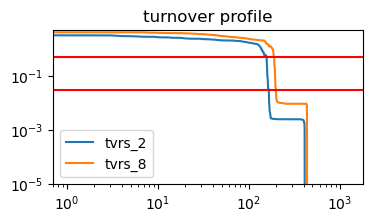

In [1]:
from glob import glob
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
files = glob(f"./pnls/*")

tvrs_2=[]
tvrs_8=[]
for f in files:
    tvr = pd.read_pickle(f)["stat_decay"]["turnover_series"]
    tvrs_2.append(np.quantile(tvr,0.2))
    tvrs_8.append(np.quantile(tvr,0.8))
pd.DataFrame({
    "tvrs_2": sorted(tvrs_2), "tvrs_8": sorted(tvrs_8)
}).iloc[::-1].reset_index(drop=True).plot(logx=True,logy=True,ylim=(1e-5, 5), title="turnover profile", figsize=(4,2))
plt.axhline(y=0.03, color="red")
plt.axhline(y=0.5, color="red")

In [2]:
dfs = [] 
for f in files:
    df = pd.read_pickle(f)
    # Error filter
    if df["stat"]["returns"] == 0:
        continue
    # Minimal robustness filter
    sharpes = pd.Series({y:df[y]["sharpe"] for y in ["stat","stat_delay","stat_decay"]})
    if sharpes.max() - sharpes.min() > 0.2:
        continue
    # Low turnover filter (overfit risk)
    if np.quantile(df["stat_decay"]["turnover_series"],0.8) < 0.03:
        continue
    # High turnover filter (tcost)
    if np.quantile(df["stat_decay"]["turnover_series"],0.2) > 0.5: # 0.10:
        continue
    dfs.append(df)

print(f"{len(dfs)}/{len(files)} Selected")

17/1265 Selected


<Axes: title={'center': 'weight profile'}>

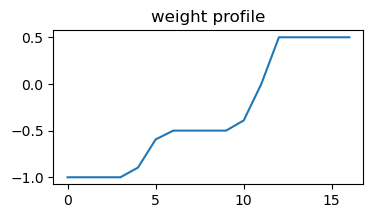

In [3]:
sharpe_threshold = 0.1
# Allows negative weight
weight_function = lambda df: \
    np.clip(np.abs(df["stat_decay"]["sharpe"])-sharpe_threshold,0,0.1) * np.sign(df["stat_decay"]["sharpe"]) \
        / np.clip(np.mean(df["stat_decay"]["turnover_series"]), 0.1, 0.2)

# Weight assignment is skewed towards low turnover
pd.Series([weight_function(df) for df in dfs]).sort_values().reset_index(drop=True).plot(title="weight profile", figsize=(4,2))

<Axes: >

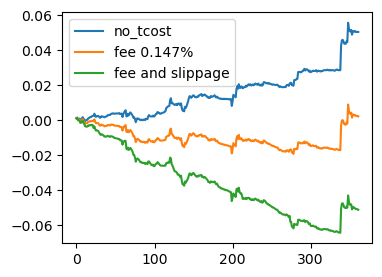

In [4]:
df_ret = pd.DataFrame({
    df["path"]: df["stat_decay"]["returns_series"] * weight_function(df) for df in dfs
}) / np.nansum([np.abs(weight_function(df)) for df in dfs])

df_fee = 1.47 * pd.DataFrame({
    df["path"]: df["stat_decay"]["fee_series"] * abs(weight_function(df)) for df in dfs
}) / np.nansum([np.abs(weight_function(df)) for df in dfs])

df_slippage = pd.DataFrame({
    df["path"]: np.abs(df["stat_decay"]["slippage_series"] * abs(weight_function(df))) for df in dfs
}) / np.nansum([np.abs(weight_function(df)) for df in dfs])

gap = 0.1 # daily gap skip
pd.DataFrame({
    "no_tcost": df_ret.sum(axis=1).clip(-gap,gap).cumsum(),
    # "fee 0.147% (no netting)": (df_ret.sum(axis=1) - df_fee.sum(axis=1) ).clip(-gap,gap).cumsum(),
    "fee 0.147%": (df_ret.sum(axis=1) - df_fee.max(axis=1) ).clip(-gap,gap).cumsum(),
    # "fee and slippage":(df_ret.sum(axis=1) - df_fee.sum(axis=1) -df_slippage.sum(axis=1) ).clip(-gap,gap).cumsum(),
    "fee and slippage":(df_ret.sum(axis=1) - df_fee.max(axis=1) -df_slippage.max(axis=1) ).clip(-gap,gap).cumsum(),
}).reset_index(drop=True).plot(figsize=(4,3))

Text(0.5, 1.0, 'Covariance')

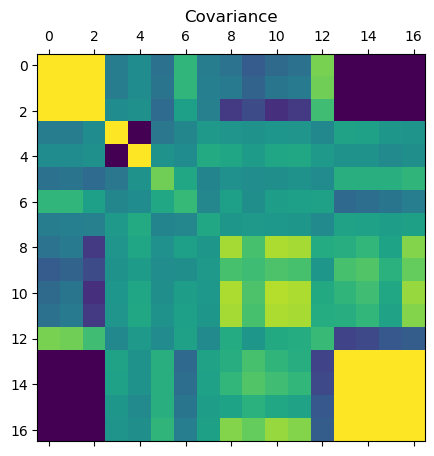

In [5]:
# About 40% of the selected alpha are duplicates
# TODO: Combination better than affine

from scipy.cluster.vq import kmeans, vq
df_r = pd.DataFrame([df["stat_decay"]["returns_series"][-100:] for df in dfs])
codebook, distortion = kmeans(df_r.values, k_or_guess=5)
cluster_idx, _ = vq(df_r.values, codebook)
f = plt.figure(figsize=(5, 5))
plt.matshow(df_r.iloc[np.argsort(cluster_idx)].T.cov().clip(-1e-5, 1e-5), fignum=f.number)
plt.title("Covariance")